In [1]:
## Load libraries
import pystac_client
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import planetary_computer

In [2]:
import numpy as np
import rtree

#Taken from https://github.com/mthh/gpd_lite_toolbox

def make_index(bounds):
    return rtree.index.Index([z for z in idx_generator_func(bounds)],
                             Interleaved=True)

def make_grid(gdf, height, cut=True):
    """
    Return a grid, based on the shape of *gdf* and on a *height* value (in
    units of *gdf*). If cut=False, the grid will not be intersected with *gdf*
    (i.e it makes a grid on the bounding-box of *gdf*).
    Parameters
    ----------
    gdf: GeoDataFrame
        The collection of polygons to be covered by the grid.
    height: Integer
        The dimension (will be used as height and width) of the ceils to create,
        in units of *gdf*.
    cut: Boolean, default True
        Cut the grid to fit the shape of *gdf* (ceil partially covering it will
        be truncated). If False, the returned grid will fit the bounding box
        of *gdf*.
    Returns
    -------
    grid: GeoDataFrame
        A collection of polygons.
    """
    from math import ceil
    from shapely.ops import unary_union
    xmin, ymin = [i.min() for i in gdf.bounds.T.values[:2]]
    xmax, ymax = [i.max() for i in gdf.bounds.T.values[2:]]
    rows = int(ceil((ymax-ymin) / height))
    cols = int(ceil((xmax-xmin) / height))

    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            res_geoms.append((
                (x_left_origin, y_top), (x_right_origin, y_top),
                (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                ))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height
    if cut:
        if all(gdf.eval(
            "geometry.type =='Polygon' or geometry.type =='MultiPolygon'")):
            res = gpd.GeoDataFrame(
                geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
                crs=gdf.crs
                ).intersection(unary_union(gdf.geometry))
        else:
            res = gpd.GeoDataFrame(
                geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
                crs=gdf.crs
                ).intersection(unary_union(gdf.geometry).convex_hull)
        res = res[res.geometry.type == 'Polygon']
        res.index = [i for i in range(len(res))]
        return gpd.GeoDataFrame(geometry=res)

    else:
        return gpd.GeoDataFrame(
            index=[i for i in range(len(res_geoms))],
            geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
            crs=gdf.crs
            )


def gridify_data(gdf, height, col_name, cut=True, method=np.mean):
    """
    Gridify a collection of point observations.
    Parameters
    ----------
    gdf: GeoDataFrame
        The collection of polygons to be covered by the grid.
    height: Integer
        The dimension (will be used as height and width) of the ceils to create,
        in units of *gdf*.
    col_name: String
        The name of the column containing the value to use for the grid cells.
    cut: Boolean, default True
        Cut the grid to fit the shape of *gdf* (ceil partially covering it will
        be truncated). If False, the returned grid fit the bounding box of gdf.
    method: Numpy/Pandas function
        The method to aggregate values of points for each cell.
        (like numpy.max, numpy.mean, numpy.mean, numpy.std or numpy.sum)
    Returns
    -------
    grid: GeoDataFrame
        A collection of polygons.
    Example
    -------
    >>> all(gdf.geometry.type == 'Point')  # The function only act on Points
    True
    >>> gdf.time.dtype  # And the value to aggreagate have to be numerical
    dtype('int64')
    >>> grid_data = gridify_data(gdf, 7500, 'time', method=np.min)
    >>> plot_dataframe(grid_data, column='time')
    <matplotlib.axes._subplots.AxesSubplot at 0x7f8336373a20>
    ...
    """
    if not all(gdf.geometry.type == 'Point'):
        raise ValueError("Can only gridify scattered data (Point)")
    if not gdf[col_name].dtype.kind in {'i', 'f'}:
        raise ValueError("Target column have to be a numerical field")

    grid = make_grid(gdf, height, cut)
    grid[col_name] = -1
    index = make_index([i.bounds for i in gdf.geometry])
    for id_cell in range(len(grid)):
        ids_pts = list(index.intersection(
            grid.geometry[id_cell].bounds, objects='raw'))
        if ids_pts:
            res = method(gdf.iloc[ids_pts][col_name])
            grid.loc[id_cell, col_name] = res
    return grid


In [3]:
import dask_gateway

# cluster = None
gateway = dask_gateway.Gateway()
cluster_options = gateway.cluster_options()



In [4]:

def check_for_existing_clusters():
    if len(gateway.list_clusters()) == 0:
        return False   
    return True

#max is 227
def setup_dask_cluster(max=227, mem=16):
    
    cluster_options["worker_memory"] = mem
    
    if check_for_existing_clusters():
        print ("Clusters already exist, latching onto the first one")
        
        clusters = gateway.list_clusters()
        cluster = gateway.connect(clusters[0].name)
        
        client = cluster.get_client()
        
    else :
        cluster = gateway.new_cluster(cluster_options, shutdown_on_close=False)
        client = cluster.get_client()
        cluster.adapt(minimum=2, maximum=max)
    
    
    print(client)
    print(cluster.dashboard_link)

    
def shutdown_all_clusters():
    
    clusters = gateway.list_clusters()
    if clusters is not None:
        for c in clusters:
            cluster = gateway.connect(c.name)
            cluster.shutdown()
            print (cluster)
    
# This function will be used to 'override' dask.conpute
# check if dask clusters are alive, if so, latch onto it
# otherwise spawn a new cluster and do .compute on df
def compute(ddf):
    setup_dask_cluster()
    return ddf.compute()

def dashboard():
    return cluster.dashboard_link
    

In [5]:
gateway.list_clusters()

[ClusterReport<name=prod.138465949dfa4f4fb6529cab73bbd16e, status=RUNNING>]

In [6]:
check_for_existing_clusters()

True

In [7]:
setup_dask_cluster()

Clusters already exist, latching onto the first one
<Client: 'tls://10.244.161.137:8786' processes=2 threads=2, memory=32.00 GiB>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.138465949dfa4f4fb6529cab73bbd16e/status


In [8]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
)
search = catalog.search(collections=["gbif"])
items = search.get_all_items()
items = {x.id: x for x in items}
item = list(items.values())[0]
item

<Item id=gbif-2022-03-01>

In [9]:
keep_cols= ['gbifid', 'datasetkey', 'occurrenceid', 'kingdom', 'phylum', 'class',\
       'order', 'family', 'genus', 'species','countrycode', 'locality',\
       'stateprovince', 'individualcount','decimallatitude', 'decimallongitude',\
       'coordinateuncertaintyinmeters', 'coordinateprecision', 'elevation',\
       'elevationaccuracy', 'depth', 'depthaccuracy', 'eventdate', 'day',
       'month', 'year', 'taxonkey', 'basisofrecord', 'issue', 'occurrencestatus']


In [10]:
min_cols = ['species','genus','countrycode','decimallatitude', 'decimallongitude','basisofrecord', 'issue', 'occurrencestatus']

Load a dask frame with the pointer to the GBIF data

In [11]:
signed_asset = planetary_computer.sign(item).assets["data"]

ddf = dd.read_parquet(
    signed_asset.href,
    columns = min_cols,
    storage_options=signed_asset.extra_fields["table:storage_options"],
    dataset={"require_extension": None},
)
ddf.npartitions

1105

In [12]:
ddf.head()

,species,genus,countrycode,decimallatitude,decimallongitude,basisofrecord,issue,occurrencestatus
0,Cymbopogon bombycinus,Cymbopogon,AU,-23.8500,151.2500,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT
1,Eremophila elderi,Eremophila,AU,-23.3167,130.3667,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT
2,Carex chlorantha,Carex,AU,-37.7000,148.4500,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT
3,Philonotis tenuis,Philonotis,AU,-35.8667,148.5000,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT
4,Senecio pinnatifolius,Senecio,AU,-37.5667,149.7500,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT


## Filter GBIF data
Possibbasisofrecordilters:
- Countrycode (CR)
- coordinateuncertaintyinmeters (< some number like 1000 or 10000m)
- dateidentified (some minimum date)
- Kingdom/Phylum/class/order/..
- Remove fossils (basisofrecord != 'FOSSIL_SPECIMEN') [Basis of Record explainer](https://gbif.github.io/gbif-api/apidocs/org/gbif/api/vocabulary/BasisOfRecord.html)
- occurrencestatus == 'PRESENT'

Maybe:
- taxonkey = 212 for all birds, etc


The Parquet file schema is described below.  Most field names correspond to [terms from the Darwin Core standard](https://dwc.tdwg.org/terms/), and have been interpreted by GBIF's systems to align taxonomy, location, dates etc.
Additional information may be retrived using the [GBIF API](https://www.gbif.org/developer/summary).

|              Field¹              |     Type      | Nullable | Description                   |
|----------------------------------|---------------|----------|-------------------------------|
| gbifid                           | BigInt        | N        | GBIF's identifier for the occurrence |
| datasetkey                       | String (UUID) | N        | GBIF's UUID for the [dataset](https://www.gbif.org/developer/registry#datasets) containing this occurrence |
| publishingorgkey                 | String (UUID) | N        | GBIF's UUID for the [organization](https://www.gbif.org/developer/registry#organizations) publishing this occurrence. |
| occurrencestatus                 | String        | N        | See [dwc:occurrenceStatus](https://dwc.tdwg.org/terms/#occurrenceStatus). Either the value `PRESENT` or `ABSENT`.  Many users will wish to filter for `PRESENT` data. |
| basisofrecord                    | String        | N        | See [dwc:basisOfRecord](https://dwc.tdwg.org/terms/#basisOfRecord).  One of `PRESERVED_SPECIMEN`, `FOSSIL_SPECIMEN`, `LIVING_SPECIMEN`, `OBSERVATION`, `HUMAN_OBSERVATION`, `MACHINE_OBSERVATION`, `MATERIAL_SAMPLE`, `LITERATURE`, `UNKNOWN`. |
| kingdom                          | String        | Y        | See [dwc:kingdom](https://dwc.tdwg.org/terms/#kingdom).  This field has been aligned with the [GBIF backbone taxonomy](https://doi.org/10.15468/39omei). |
| phylum                           | String        | Y        | See [dwc:phylum](https://dwc.tdwg.org/terms/#phylum).  This field has been aligned with the GBIF backbone taxonomy. |
| class                            | String        | Y        | See [dwc:class](https://dwc.tdwg.org/terms/#class).  This field has been aligned with the GBIF backbone taxonomy. |
| order                            | String        | Y        | See [dwc:order](https://dwc.tdwg.org/terms/#order).  This field has been aligned with the GBIF backbone taxonomy. |
| family                           | String        | Y        | See [dwc:family](https://dwc.tdwg.org/terms/#family).  This field has been aligned with the GBIF backbone taxonomy. |
| genus                            | String        | Y        | See [dwc:genus](https://dwc.tdwg.org/terms/#genus).  This field has been aligned with the GBIF backbone taxonomy. |
| species                          | String        | Y        | See [dwc:species](https://dwc.tdwg.org/terms/#species).  This field has been aligned with the GBIF backbone taxonomy. |
| infraspecificepithet             | String        | Y        | See [dwc:infraspecificEpithet](https://dwc.tdwg.org/terms/#infraspecificEpithet).  This field has been aligned with the GBIF backbone taxonomy. |
| taxonrank                        | String        | Y        | See [dwc:taxonRank](https://dwc.tdwg.org/terms/#taxonRank).  This field has been aligned with the GBIF backbone taxonomy. |
| scientificname                   | String        | Y        | See [dwc:scientificName](https://dwc.tdwg.org/terms/#scientificName).  This field has been aligned with the GBIF backbone taxonomy. |
| verbatimscientificname           | String        | Y        | The scientific name as provided by the data publisher |
| verbatimscientificnameauthorship | String        | Y        | The scientific name authorship provided by the data publisher. |
| taxonkey                         | Integer       | Y        | The numeric identifier for the [taxon](https://www.gbif.org/developer/species#nameUsages) in GBIF's backbone taxonomy corresponding to `scientificname`. |
| specieskey                       | Integer       | Y        | The numeric identifier for the taxon in GBIF's backbone taxonomy corresponding to `species`. |
| typestatus                       | String        | Y        | See [dwc:typeStatus](https://dwc.tdwg.org/terms/#typeStatus). |
| countrycode                      | String        | Y        | See [dwc:countryCode](https://dwc.tdwg.org/terms/#countryCode).  GBIF's interpretation has set this to an ISO 3166-2 code. |
| locality                         | String        | Y        | See [dwc:locality](https://dwc.tdwg.org/terms/#locality). |
| stateprovince                    | String        | Y        | See [dwc:stateProvince](https://dwc.tdwg.org/terms/#stateProvince). |
| decimallatitude                  | Double        | Y²       | See [dwc:decimalLatitude](https://dwc.tdwg.org/terms/#decimalLatitude).  GBIF's interpretation has normalized this to a WGS84 coordinate. |
| decimallongitude                 | Double        | Y²       | See [dwc:decimalLongitude](https://dwc.tdwg.org/terms/#decimalLongitude).  GBIF's interpretation has normalized this to a WGS84 coordinate. |
| coordinateuncertaintyinmeters    | Double        | Y        | See [dwc:coordinateUncertaintyInMeters](https://dwc.tdwg.org/terms/#coordinateUncertaintyInMeters). |
| coordinateprecision              | Double        | Y        | See [dwc:coordinatePrecision](https://dwc.tdwg.org/terms/#coordinatePrecision). |
| elevation                        | Double        | Y        | See [dwc:elevation](https://dwc.tdwg.org/terms/#elevation).  If provided by the data publisher, GBIF's interpretation has normalized this value to metres. |
| elevationaccuracy                | Double        | Y        | See [dwc:elevationAccuracy](https://dwc.tdwg.org/terms/#elevationAccuracy).  If provided by the data publisher, GBIF's interpretation has normalized this value to metres. |
| depth                            | Double        | Y        | See [dwc:depth](https://dwc.tdwg.org/terms/#depth).  If provided by the data publisher, GBIF's interpretation has normalized this value to metres. |
| depthaccuracy                    | Double        | Y        | See [dwc:depthAccuracy](https://dwc.tdwg.org/terms/#depthAccuracy).  If provided by the data publisher, GBIF's interpretation has normalized this value to metres. |
| eventdate                        | String        | Y        | See [dwc:eventDate](https://dwc.tdwg.org/terms/#eventDate).  GBIF's interpretation has normalized this value to an ISO 8601 date with a local time. |
| year                             | Integer       | Y        | See [dwc:year](https://dwc.tdwg.org/terms/#year). |
| month                            | Integer       | Y        | See [dwc:month](https://dwc.tdwg.org/terms/#month). |
| day                              | Integer       | Y        | See [dwc:day](https://dwc.tdwg.org/terms/#day). |
| individualcount                  | Integer       | Y        | See [dwc:individualCount](https://dwc.tdwg.org/terms/#individualCount). |
| establishmentmeans               | String        | Y        | See [dwc:establishmentMeans](https://dwc.tdwg.org/terms/#establishmentMeans). |
| occurrenceid                     | String        | Y³       | See [dwc:occurrenceID](https://dwc.tdwg.org/terms/#occurrenceID). |
| institutioncode                  | String        | Y³       | See [dwc:institutionCode](https://dwc.tdwg.org/terms/#institutionCode). |
| collectioncode                   | String        | Y³       | See [dwc:collectionCode](https://dwc.tdwg.org/terms/#collectionCode). |
| catalognumber                    | String        | Y³       | See [dwc:catalogNumber](https://dwc.tdwg.org/terms/#catalogNumber). |
| recordnumber                     | String        | Y        | See [dwc:recordNumber](https://dwc.tdwg.org/terms/#recordNumber). |
| recordedby                       | String        | Y        | See [dwc:recordedBy](https://dwc.tdwg.org/terms/#recordedBy). |
| identifiedby                     | String        | Y        | See [dwc:identifiedBy](https://dwc.tdwg.org/terms/#identifiedBy). |
| dateidentified                   | String        | Y        | See [dwc:dateIdentified](https://dwc.tdwg.org/terms/#dateIdentified). An ISO 8601 date. |
| mediatype                        | String array  | N⁴       | See [dwc:mediaType](https://dwc.tdwg.org/terms/#mediaType).  May contain `StillImage`, `MovingImage` or `Sound` (from [enumeration](http://api.gbif.org/v1/enumeration/basic/MediaType), detailing whether the occurrence has this media available. |
| issue                            | String array  | N⁴       | A list of [issues](https://gbif.github.io/gbif-api/apidocs/org/gbif/api/vocabulary/OccurrenceIssue.html) encountered by GBIF in processing this record. More details are available on these issues and flags in [this blog post](https://data-blog.gbif.org/post/issues-and-flags/).|
| license                          | String        | N        | See [dwc:license](https://dwc.tdwg.org/terms/#license). Either [`CC0_1_0`](https://creativecommons.org/publicdomain/zero/1.0/) or [`CC_BY_4_0`](https://creativecommons.org/licenses/by/4.0/).  `CC_BY_NC_4_0` records are not present in this snapshot. |
| rightsholder                     | String        | Y        | See [dwc:rightsHolder](https://dwc.tdwg.org/terms/#rightsHolder). |
| lastinterpreted                  | String        | N        | The ISO 8601 date when the record was last processed by GBIF. Data are reprocessed for several reasons, including changes to the backbone taxonomy, so this date is not necessarily the date the occurrence record last changed. |

¹ Field names are lower case, but in later snapshots this may change to camelCase, for consistency with Darwin Core and the GBIF API.

² Occurrences without coordinates are excluded from this snapshot, although this may change in the future.

³ Either `occurrenceID`, or `institutionCode` + `collectionCode` + `catalogNumber`, or both, will be present on every record.

⁴ The array may be empty.


In [13]:
gbif_cr = ddf.loc[ddf.countrycode == 'CR']

In [14]:
gbif_cr = gbif_cr.loc[gbif_cr.basisofrecord != 'FOSSIL_SPECIMEN']
gbif_cr = gbif_cr.loc[gbif_cr.occurrencestatus == 'PRESENT']


In [15]:
#len(gbif_cr.index)

### Drop Columns

Consider keeping ['issue'](https://gbif.github.io/gbif-api/apidocs/org/gbif/api/vocabulary/OccurrenceIssue.html) for later filtering

In [16]:
gbif_cr_min = gbif_cr.drop(['basisofrecord','occurrencestatus','issue'], axis=1)

In [17]:
gbif_cr_min.columns

Index(['species', 'genus', 'countrycode', 'decimallatitude',
       'decimallongitude'],
      dtype='object')

In [18]:
#sanity check
# df = gbif_cr_min.drop(['genus','decimallatitude','decimallongitude'], axis=1)
# species_per_country = df.groupby("countrycode").species.nunique()
# species_per_country

In [19]:
# species_per_country_df = species_per_country.compute()

In [20]:
# species_per_country_df

------------------------------------------------
Convert dask df directly to dask-geopandas df

! Didnt Work!


In [21]:
# setup_dask_cluster()
gbif_cr_min

,species,genus,countrycode,decimallatitude,decimallongitude
npartitions=1105,,,,,
,object,object,object,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


### Reduce resolution

Use a dirty trick of reducing the number of decimal points to align a point to some closest lat/lon line

- Rule of thumb: 1 deg lon/lat (atleast near the equator for lat, always for lon) = 111km
- e.g. round the inherent lat/lons to 2 decimal points (82.37654 -> 82.38) will align all points to 0.01 degrees (or approx 1.11km apart)

In [22]:

def reduce_resolution_dirty(ddf, dec=1):
                                
    ddf[['decimallatitude','decimallongitude']] = ddf[['decimallatitude','decimallongitude']]\
    .apply(lambda x: pd.Series.round(x, dec), meta={'decimallatitude': 'float64', 'decimallongitude': 'float64'},\
           axis=1)
    return ddf
    

In [23]:
gbif_cr_min_round = reduce_resolution_dirty(gbif_cr_min,2)
gbif_cr_min_round

,species,genus,countrycode,decimallatitude,decimallongitude
npartitions=1105,,,,,
,object,object,object,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


### Derive numerical values for species richness


We will be focusing on alpha specied richness, which is simply the count of unique species within a given region.
Here the region is our chosen grid size.

In [24]:
cr_species = gbif_cr_min_round.groupby(['decimallatitude','decimallongitude']).species.nunique().reset_index()

# apply to a small chunk
# cr_species = gbif_cr_min_round.partitions[5].groupby(['decimallatitude','decimallongitude']).species.nunique().compute().reset_index()

In [25]:
cr_species

,decimallatitude,decimallongitude,species
npartitions=1,,,
,float64,float64,int64
,...,...,...


### Lets try out dask_geopandas

But first we have to convert to geopandas, sadly. I have not found a way to go from dask -> dask_geopandas, so:

- dask -> geopandas -> dask_geopandas

In [28]:
setup_dask_cluster()
cr_species_gpd = gpd.GeoDataFrame(cr_species.compute(),\
                                  geometry=gpd.points_from_xy(cr_species['decimallongitude'],\
                                                              cr_species['decimallatitude']), crs = "EPSG:4326")

# cr_species_gpd = gpd.GeoDataFrame(cr_species,\
#                                   geometry=gpd.points_from_xy(cr_species['decimallongitude'],\
#                                                               cr_species['decimallatitude']), crs = "EPSG:4326")

Clusters already exist, latching onto the first one
<Client: 'tls://10.244.161.137:8786' processes=2 threads=2, memory=32.00 GiB>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.138465949dfa4f4fb6529cab73bbd16e/status


In [29]:
cr_species_gpd

,decimallatitude,decimallongitude,species,geometry
0,8.65,-83.58,5,POINT (-83.58000 8.65000)
1,8.78,-82.96,1045,POINT (-82.96000 8.78000)
2,8.92,-83.08,16,POINT (-83.08000 8.92000)
3,9.07,-83.08,233,POINT (-83.08000 9.07000)
4,9.57,-83.77,90,POINT (-83.77000 9.57000)
...,...,...,...,...
25422,9.77,-84.95,1,POINT (-84.95000 9.77000)
25423,10.29,-83.43,1,POINT (-83.43000 10.29000)
25424,10.51,-85.54,1,POINT (-85.54000 10.51000)
25425,10.85,-85.52,1,POINT (-85.52000 10.85000)


In [30]:
cr_species_gpd_clean = cr_species_gpd.drop(columns=['decimallatitude','decimallongitude'])
cr_species_gpd_clean

,species,geometry
0,5,POINT (-83.58000 8.65000)
1,1045,POINT (-82.96000 8.78000)
2,16,POINT (-83.08000 8.92000)
3,233,POINT (-83.08000 9.07000)
4,90,POINT (-83.77000 9.57000)
...,...,...
25422,1,POINT (-84.95000 9.77000)
25423,1,POINT (-83.43000 10.29000)
25424,1,POINT (-85.54000 10.51000)
25425,1,POINT (-85.52000 10.85000)


In [38]:
# cr_species_gpd_clean.to_parquet('cr_species_gpd_clean.parquet')
cr_species_gpd_clean.to_file('cr_species_gpd_clean.shp')  

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [42]:
type(cr_species_gpd_clean)
cr_species_gpd_clean.index.is_monotonic_increasing

True

In [49]:
import dask_geopandas as dgpd

#spatial shuffle will organize the partitions spatially
cr_species_dgpd = dgpd.from_geopandas(cr_species_gpd_clean, npartitions=1000)

In [50]:
cr_species_dgpd

,species,geometry
npartitions=978,,
0,int64,geometry
26,...,...
...,...,...
25402,...,...
25426,...,...


In [47]:
type(cr_species_dgpd)
# cr_species_dgpd_opt = cr_species_dgpd.spatial_shuffle()

dask_geopandas.core.GeoDataFrame

#### Do some sanity checking by plotting

In [53]:
# slice5 = cr_species_ddf.partitions[5].compute()
slice5 = compute(cr_species_dgpd.partitions[5])
slice5

Clusters already exist, latching onto the first one
<Client: 'tls://10.244.161.137:8786' processes=2 threads=2, memory=32.00 GiB>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.138465949dfa4f4fb6529cab73bbd16e/status


,species,geometry
130,35,POINT (-83.46000 8.74000)
131,1,POINT (-83.22000 8.74000)
132,2,POINT (-83.23000 8.75000)
133,139,POINT (-83.04000 8.75000)
134,1524,POINT (-83.28000 8.76000)
135,11,POINT (-83.04000 8.76000)
136,18,POINT (-83.61000 8.77000)
137,693,POINT (-83.26000 8.77000)
138,83,POINT (-83.05000 8.77000)
139,42,POINT (-83.18000 8.78000)


<AxesSubplot:>

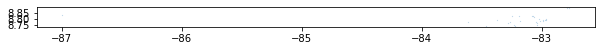

In [52]:
slice5.plot(markersize=0.01, figsize=(10,10))

## Get the hires polygon for CR

In [54]:
countries = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")
cr_vec_hires = countries[countries.ISO_A2 == 'CR']
cr_vec_hires

,ADMIN,ISO_A3,ISO_A2,geometry
53,Costa Rica,CRI,CR,"MULTIPOLYGON (((-87.09903 5.51602, -87.11767 5..."


In [55]:
cr_vec_hires['geometry'] = cr_vec_hires['geometry'].set_crs("EPSG:4326")

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Set a bounding box to exclude the polygon for Cocos Island

We manually trim the polygons by creating a bounding box

<AxesSubplot:>

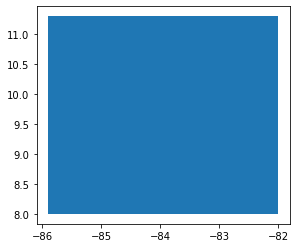

In [56]:
#Create a bounding box for terrestrial CR

from shapely.geometry import Polygon
import shapely as sh


lon_point_list = [-85.9, -82, -82, -85.9]
lat_point_list = [11.3, 11.3, 8, 8]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = 'epsg:4326'
bounding_box = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
bounding_box.plot()

<AxesSubplot:>

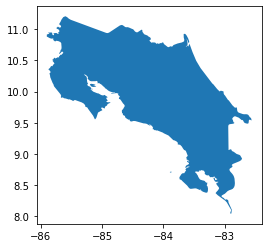

In [57]:
cr_terra = gpd.overlay(cr_vec_hires, bounding_box, how='intersection')
# intersecting = cr_polygon.sjoin(b_box_df, how='inner')['savedindex'] #Find the polygons that intersect. Keep savedindex as a series
cr_terra.plot()

### Clip to terrestrial CR

In [59]:
cr_species_terra_gpdd = dgpd.clip(cr_species_dgpd,cr_terra)
cr_species_terra_gpdd

,species,geometry
npartitions=978,,
0,int64,geometry
26,...,...
...,...,...
25402,...,...
25426,...,...


In [ ]:

cr_species_terra_gpdd.to_parquet('../data/cr_species_terra_gpdd.parquet')

### Using just one partition to test

Plot it

In [64]:
# slice5 = cr_species_terra_gpdd.partitions[5].compute()
slice = compute(cr_species_terra_gpdd)

Clusters already exist, latching onto the first one
<Client: 'tls://10.244.161.137:8786' processes=2 threads=2, memory=32.00 GiB>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.138465949dfa4f4fb6529cab73bbd16e/status


(-86.06685815630001, -82.3959787176999, 7.875988569477026, 11.368696482596494)

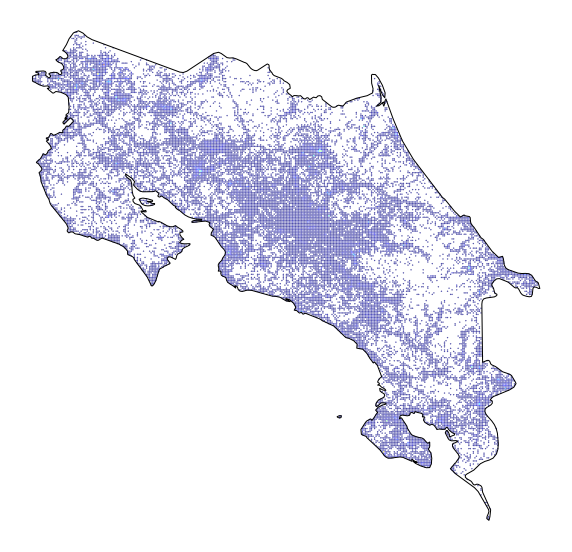

In [65]:
ax = slice.plot(markersize=0.1, figsize=(10,10), column = 'species', cmap='jet')
cr_terra.to_crs(slice5.crs).plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

In [68]:
slice.head(10)

,species,geometry
20,49,POINT (-83.50000 8.50000)
0,5,POINT (-83.58000 8.65000)
21,87,POINT (-83.67000 8.67000)
22,137,POINT (-82.97000 8.75000)
1,1045,POINT (-82.96000 8.78000)
2,16,POINT (-83.08000 8.92000)
23,78,POINT (-82.83000 8.92000)
3,233,POINT (-83.08000 9.07000)
24,109,POINT (-83.75000 9.33000)
25,140,POINT (-83.67000 9.33000)


### Convert from point to raster

Using Geocube functions - failed on first tests, need to retry

In [69]:
import json
from functools import partial

from shapely.geometry import box, mapping

from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

In [76]:

out_grid = make_geocube(vector_data=slice, measurements=["species"], resolution=(-0.01, 0.01))# , \
                        #rasterize_function=partial(rasterize_points_griddata, method="cubic")) #for most crs negative comes first in resolution



In [75]:
# out_grid.test_attr.where(out_grid.test_attr!=out_grid.test_attr.rio.nodata).plot()
out_grid.rio.to_raster('cr_species.tif')
# out_grid["species"].rio.to_raster("my_rasterized_column.tif")

In [77]:
out_grid

<xarray.Dataset>
Dimensions:      (y: 316, x: 332)
Coordinates:
  * y            (y) float64 11.2 11.19 11.18 11.17 ... 8.075 8.065 8.055 8.045
  * x            (x) float64 -85.9 -85.89 -85.88 -85.87 ... -82.61 -82.6 -82.59
    spatial_ref  int64 0
Data variables:
    species      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
#slice5_grid = make_grid(slice5_clean, 0.009) #roughly 1kmx1km